# Timeseries Airbnb

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

sns.set()
sns.set_context("talk")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Inspect Data
- data types
- dataset size (rows and columns)
- create descriptive statistics to summarize a distribution's the central tendency, dispersion and shape

In [3]:
df = pd.read_csv("./data/reviews_paris.csv")

display(df.shape, df.dtypes, df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

df.head(5)

(1103367, 2)

listing_id     int64
date          object
dtype: object

,listing_id
count,1.103367e+06
mean,1.017928e+07
std,8.061945e+06
min,3.109000e+03
25%,2.788739e+06
50%,8.362211e+06
75%,1.654273e+07
85%,2.000795e+07
95%,2.474977e+07
99%,2.812357e+07


,listing_id,date
0,3109,2016-12-27
1,3109,2016-12-28
2,3109,2017-10-28
3,3109,2017-11-03
4,3109,2018-02-12


# Transform The Data
- rename the columns
- group data by date and aggregate the number of reviews for each date
- convert the date series to a datetime64/int64 date column and use that as an index
- convert TimeSeries to a 1 Day Frequency and impute missing data with a 0

In [4]:
df = df.rename(columns={"date": "ds", "listing_id": 'ts'})

df2 = df.groupby(by="ds").agg({"ts": "count"})
 
df2.index = pd.to_datetime(df2.index)

df2.asfreq(freq='1D', fill_value=0)

df2.sort_index(ascending=True)

# inspect n values from a dataframe's head and tail
def ht_inspect(df, window = 10):
    return df.iloc[np.r_[0:window, (-1 * window):0]]

ht_inspect(df=df2, window = 5)

,ts
ds,
2009-06-30,1
2009-07-03,1
2009-07-08,1
2009-09-10,1
2009-09-28,1
2018-12-04,400
2018-12-05,338
2018-12-06,292
2018-12-07,162


# Plot the Time Series

Text(0.5, 0, 'Review Date')

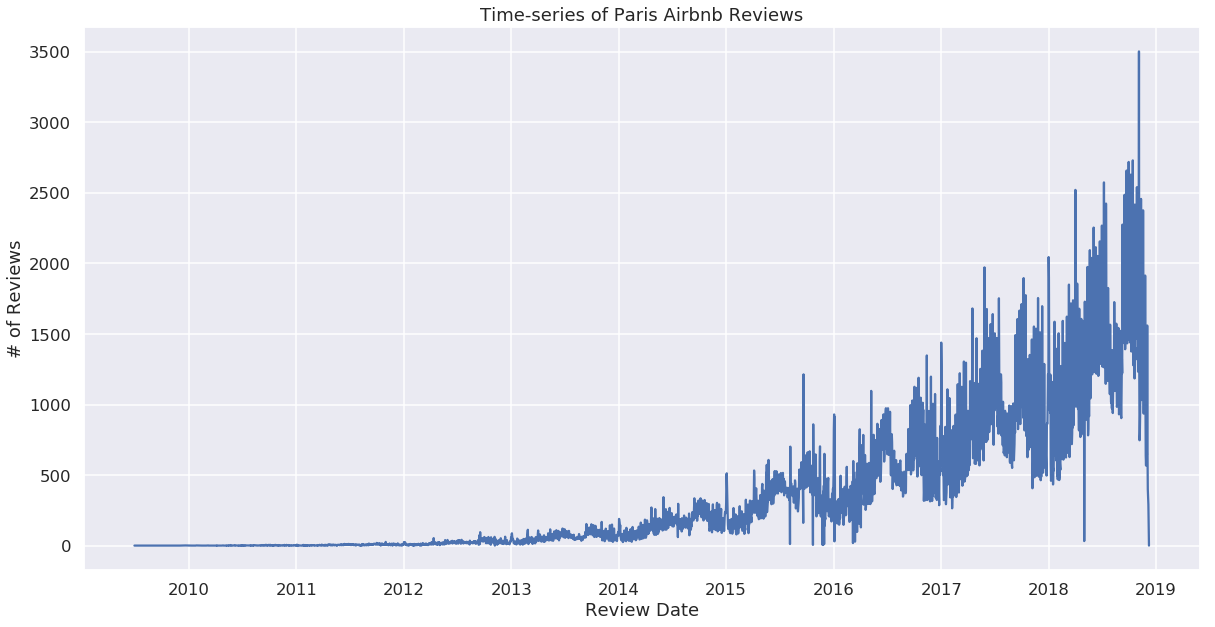

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.plot(df2[['ts']])

ax.set_title('Time-series of Paris Airbnb Reviews')
ax.set_ylabel('# of Reviews')
ax.set_xlabel('Review Date')

# ax.tick_params(axis = 'x', rotation = 45)

# Determine Data Stationarity
### Criterion:
- Mean must remain constant
- Variance must remain constant
- Autocovariance must remain constant

Without a Stationary Time Series, we cannot build a time series model. To determine Stationarity, we'll use the Standard Deviation and Mean from rolling window calculations with 12 observations and the Augmented Dickey-Fuller test.

The Augmented Dickey-Fuller test tests for a unit root in a univariate process in timeseries data. The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null. The more negative  the ADF Statistics is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

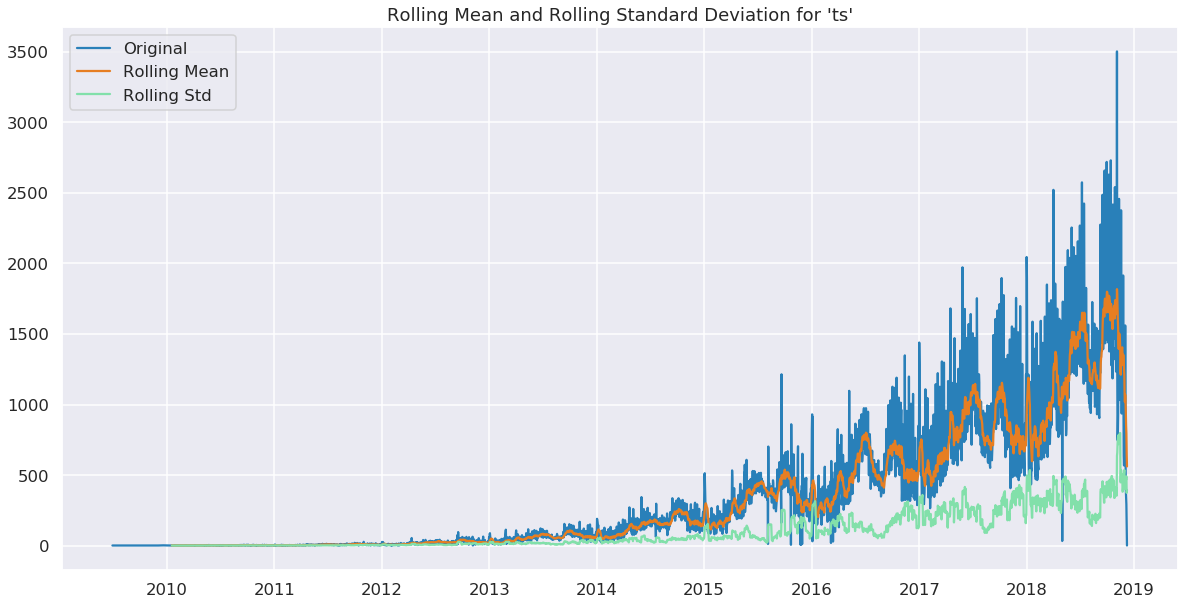


-------------------------------------
Dickey-Fuller Test:
-------------------------------------
          
ADF Test Statistic          -2.161472
p-value                      0.220525
# of lags used              29.000000
# of observations used    3089.000000
Critical Value 1%           -3.432469
Critical Value 5%           -2.862476
Critical Value 10%          -2.567268
dtype: float64


In [9]:
def stationarity(df, timeseries):
    window = df2[timeseries].rolling(window = 12)
    
    return {"rolling_mean": window.mean(), "rolling_stdev": window.std()}

def plot_stationarity(s, ts):
    plt.figure(figsize=(20,10))
    orig = plt.plot(df2[ts], color = "#2980B9", label = "Original")
    mean = plt.plot(s["rolling_mean"], color = "#E67E22", label = "Rolling Mean")
    std = plt.plot(s["rolling_stdev"], color = "#82E0AA", label = "Rolling Std")
    plt.title(f"Rolling Mean and Rolling Standard Deviation for \'{ts}\'")

    plt.legend()
    plt.show()
    
    plt.close()

def dickey_fuller_test(df, timeseries):
    test = adfuller(df[timeseries])
    c_vals = lambda c : tuple(c.values())
    
    print("""
-------------------------------------
Dickey-Fuller Test:
-------------------------------------
          """)
    print(pd.Series(test[:4] + c_vals(test[4]), index=["ADF Test Statistic", "p-value", "# of lags used", "# of observations used", "Critical Value 1%", "Critical Value 5%", "Critical Value 10%"]))

s = stationarity(df = df2, timeseries = "ts")
    
plot_stationarity(s, "ts")
dickey_fuller_test(df = df2, timeseries = "ts")

# Improving Stationarity